In [201]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
raw_data = pd.read_csv('train.csv')
boxplots = pd.read_csv('BoxPlots.tsv', sep='\t', index_col=0)
boxplots = boxplots[['normal', 'left', 'right']]
data = raw_data.copy()

I'm going to extract some additional features and visually explore them. The goal of this workbook and subsequent post is a meta exploration of a dataset. Taking a step back from modeling the idea is to think about how best to get comfortable with a dataset, what to watch out for and why.

In [62]:
# Make an inference about the passenger given their title
title_inferences = {'unmarried_female': ['Miss', 'Mlle', 'Ms', 'Mme'],
                    'occupational_title': ['Col', 'Major', 'Capt', 'Dr', 'Rev'],
                    'married_female': ['Mrs'],
                    'man': ['Mr'],
                    'boy': ['Master'],
                    'noble': ['Jonkheer', 'Sir', 'Don', 'the Countess', 'Lady']}

def map_inference(name, mapping):
    start = name.find(',') + 2
    end = name.find('.')
    passenger_title = name[start:end]      
    for title_inference in title_inferences.keys():
        if passenger_title in title_inferences[title_inference]:            
            return title_inference
    
data['title_inference'] = data.Name.apply(map_inference, mapping=title_inferences)

# Define age groups 
def age_group(age):
    if age <= 10:
        return 'Child'
    if (age > 10) & (age <= 18):
        return 'Teenager'
    if (age > 18) & (age <= 25):
        return 'Young_adult'
    if (age > 25) & (age <= 35):
        return 'Adult'
    if (age > 35) & (age <= 50):
        return 'Middle_age'
    if age > 50:
        return 'Old'
    
data['age_group'] = data.Age.apply(age_group)

# Traveling without family
data['not_with_fam'] = data.apply(lambda row: 'Without' if row.SibSp == 0 and row.Parch == 0 else 'With', axis=1)

# Traveling with sibling and/or spouse
data['with_sibsp'] = data.apply(lambda row: 'With' if row.SibSp > 0 else 'Without', axis=1)

# Traveling with parent and/or child
data['with_parchild'] = data.apply(lambda row: 'With' if row.Parch > 0 else 'Without', axis=1)

# Traveling on a group ticket
data['ticket_headcount'] = data.groupby('Ticket')['Ticket'].transform('count')
data['on_group_ticket'] = data.apply(lambda row: 'Group' if row.ticket_headcount > 1 else 'Single', axis=1)
data.drop(columns=['ticket_headcount'], inplace=True)

In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [64]:
# For categorical features calculat survival rate & pasenger total in subgroup within category
categorical_features = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch', 'title_inference', 'age_group', 'not_with_fam',
                        'with_sibsp', 'with_parchild', 'on_group_ticket']

for feature in categorical_features:
    print(f'\nFeature: {feature}\n')
    subset = data[['Survived', feature]]   
    categories = data[feature].unique()
    if categories.dtype in ('float64', 'int64'):
        categories = sorted(categories)
    for category in categories:
        groupset = subset[subset[feature] == category]
        groupcould = len(groupset)
        print(f'{category}: Survival rate {groupset.Survived.mean():.2%} Group Count = {groupcould}')
    print('-'*30)


Feature: Pclass

1: Survival rate 62.96% Group Count = 216
2: Survival rate 47.28% Group Count = 184
3: Survival rate 24.24% Group Count = 491
------------------------------

Feature: Sex

male: Survival rate 18.89% Group Count = 577
female: Survival rate 74.20% Group Count = 314
------------------------------

Feature: Embarked

S: Survival rate 33.70% Group Count = 644
C: Survival rate 55.36% Group Count = 168
Q: Survival rate 38.96% Group Count = 77
nan: Survival rate nan% Group Count = 0
------------------------------

Feature: SibSp

0: Survival rate 34.54% Group Count = 608
1: Survival rate 53.59% Group Count = 209
2: Survival rate 46.43% Group Count = 28
3: Survival rate 25.00% Group Count = 16
4: Survival rate 16.67% Group Count = 18
5: Survival rate 0.00% Group Count = 5
8: Survival rate 0.00% Group Count = 7
------------------------------

Feature: Parch

0: Survival rate 34.37% Group Count = 678
1: Survival rate 55.08% Group Count = 118
2: Survival rate 50.00% Group Count =

In [65]:
continous_features = ['Age', 'Fare']

OK - I have a set of features some of which are continuous and others categorical.

I want to explore them.

But first, how and why do we label data as continuous or categoric?


The numerical values between a range of any two numbers is quintessentially continuous. 

I'm not thinking of these values as representing anything other than the numbers themselves. 

So the array of possible values is an infinite expanse. 

My quintessential categorical was to be sex but I reconsidered and settled with martial status.

The differentiating line between classes is whether a feature is more or less similar to either the infinite void or the black & white. 


The reason I thought about this classification is because the label we apply shapes our thinking about how to explore the feature. 

For good reason - features like height and weight will have summary statistics but not so for gender. 


So let's start with Age, look at the summary statistics & the breakdown by survival status.

In [66]:
print('Feature: Age')
for statistic, value in data.Age.describe().iteritems():
    print(f'{statistic.title()}: {value:0.2f}')

Feature: Age
Count: 714.00
Mean: 29.70
Std: 14.53
Min: 0.42
25%: 20.12
50%: 28.00
75%: 38.00
Max: 80.00


Of the 891 passengers in the training set we have the age attribute for 714 passengers. 

The age ranges from less than a year old to 80 with a mean of 30 and a median of 28. 

I'm interest in how the age range differs between the two passenger outcomes.

I could subset the data and recalculate the summary statistics for each set but instead I will use visual assistance from a boxplot.

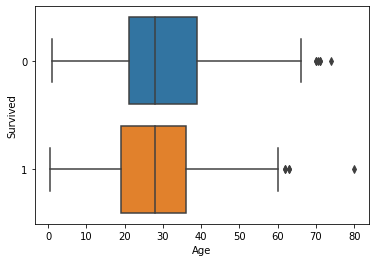

In [67]:
# Boxplot of Age by Survival Status
ax = sns.boxplot(x="Age", y="Survived", data=data, orient="h")

The boxplot gives better information about the data distribution and we can easily compare set specific summary statistics.

Each box encompasses the interquartile range with a black line denoting the median. 

The box has whiskers which extend out to the maximum & minimum ages that don't qualify as outliers.

An outlier is defined as any value that lies outside of the first/third quartile +- IQR * 1.5.

1.5 is used by convention.

The data points that lie outside this range are potential outliers and are marked on the boxplot by the black dots. 

The maximum & minimum range therefore aren't always the actual maximum and minimum values in the dataset.


If there are outliers present, the fences will extend out to the maximum/minimum value in the dataset excluding the outliers as defined.

If not, the whiskers will extend out to the maximum or minimum observation.

This gives a good feel for how the data is dispersed however it doesn't tell everything.

To get a visual feel for the shape of the distribution we will use a histogram.

1. https://www.autodeskresearch.com/publications/samestats

Going back to our example of the prime continuous feature the count of each individual number can be one despite the total count of observations being infinity.

So the count of individual observations for a continuous feature may not give us an intuitive feel for how densely the observations fall around certain values. 

To combat this we group observations in bins and use a histogram to plot the count in each bin.

Below is a histogram continuing the theme of subplots for each passenger outcome.

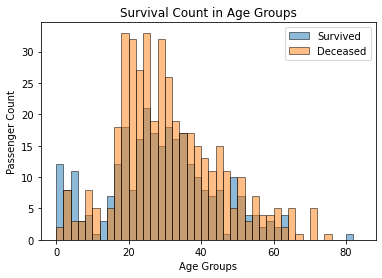

In [179]:
Survived = data[data.Survived.isin([1])]
Deceased = data[data.Survived.isin([0])]
bins = list(range(0, 85, 2))
 
plt.hist(Survived.Age[Survived.Age.notnull()], bins=bins, alpha=0.5, label='Survived', edgecolor='black')
plt.hist(Deceased.Age[Deceased.Age.notnull()], bins=bins, alpha=0.5, label='Deceased', edgecolor='black')
plt.legend(loc='upper right')
plt.title('Survival Count in Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Passenger Count')
plt.show()

I have chosen the bins as spanning 2 years over the range of values in the dataset because it intuitive to grasp with Age as the feature. 

The histogram gives a view on the data's shape that is hidden from us with the boxplot.

It is particularly useful in identifying whether the data contains significant clusters of observations outside of the  peak, or whether the dataset contains multiple peaks.

Above we can see a small cluster of younger passengers between 0 & 6 years old.

Clusters outside of the modal peak can be hidden from a boxplot. 

There has been excellent research done here to show the limitations of the boxplot in accessing data distributions.

The boxplot is the same of all three distributions below but clearly they are radically different.

[]

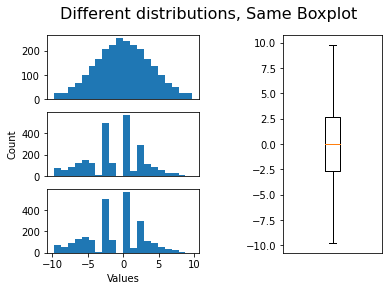

In [181]:
# set up figure & add subplots
fig = plt.figure()
fig.suptitle('Different distributions, Same Boxplot', fontsize=16)
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,3)
ax3 = fig.add_subplot(3,2,5)
ax4 = fig.add_subplot(1,3,3)

# plot histograms vs boxplot
ax1.hist(boxplots['normal'], bins=20)
ax1.set_xticklabels([])
ax1.set_xticks([])
ax2.hist(boxplots['left'], bins=20)
ax2.set_xticklabels([])
ax2.set_xticks([])
ax2.set_ylabel('Count')
ax3.hist(boxplots['left'], bins=20)
ax3.set_xlabel('Values')
ax4.boxplot(boxplots['left'])
ax4.set_xticks([])

When looking at a histogram we actively or passively make assumptions about the underlying population distribution from the shape presented. 

The question we are trying to answer concerns the population distribution but we infer from the sample plotted.  

To aid this histograms can be plotted as relative densities. 

Relative density is the width of each bar * the relative proportion of observations within each bin as a proportion of the total observations. 

Where histograms fall short is the their assumptions regarding bin width, because the bins aren't centered on the data points. 

Looking at the cluster of young passengers above we are unable to tell if the all the passengers in this set where in the 0-0.2 ran or whether they were evenly spread out amoung the entire bin width. 

This issue is caused because the blocks aren't centered on the datapoints, instead they are centered over the range of the bin width.

What if we can centre a block ontop of each datapoint and plot the stack of overlapping blocks.

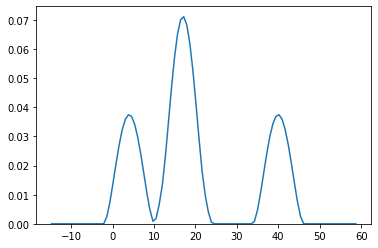

In [240]:
# define a figure, x axis value is going to be the age datapoint +/- constant, y value is a constant
datapoints = [4, 16, 18, 40]

def return_coordinates(point, offset=4):
    x_left = point - offset
    x_right = point + offset
    return (x_left, x_right, y_left, y_right)


fig, ax = plt.subplots()
for datapoint in datapoints:
    ax.add_patch(patches.Rectangle((datapoint - 4, 0), 8, 8))
plt.ylim(0, 80)
plt.xlim(0, 80)

# We know the area coordinates covered by each block by it's value, so if the datapoints value is 19, then we know it 
# 16.5-21.5 on x axis and 0-5 on y axis. If we track which x-axis area is covered we can adjust blocks up a notch if
# they are due to be laid on a covered area. 

In [1]:
datapoints = (2, 2, 5, 6, 7)
return_coordinates = lambda x: (x - 1, x, x + 1)
block_coordinates = map(return_coordinates, datapoints)

In [2]:
list(block_coordinates)

[(1, 2, 3), (1, 2, 3), (4, 5, 6), (5, 6, 7), (6, 7, 8)]

In [3]:
dimensions = [[]]

for block in block_coordinates:
    for mini_block in block:
        # If miniblock now in dimension add it into the dimension 
        # If minimblock now in any dimensions, add another dimension with it in it 
print(dimensions)

IndentationError: expected an indented block (<ipython-input-3-526affffa668>, line 7)

KDE with violin plots.

How density estimation works.

Visual dangers of smooth KDE, black swan in the ranks.

Plots are used to get a quick feel for the attributes of a dataset and there is a tradeoff between simplifying matters so their major points are be quickly grasped and rubbing over intricacies that turn out to be significant.

The histogram is a plot of raw data so at least you know where the data are.